# Rascunho

In [2]:
import numpy as np
import pystan as ps
import sympy as sp

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
sns.set()

from scipy.special import expit, logit

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

In [99]:
compiled = True
#compiled = False

if compiled: 
    sm1 = pickle.load(open('../models/extra/sketch-v1.pkl', 'rb'))
else: 
    sm1 = ps.StanModel(file = '../models/extra/sketch-v1.stan')
    with open('../models/extra/sketch-v1.pkl', 'wb') as f:
        pickle.dump(sm1, f)
        
compiled = True
#compiled = False

if compiled: 
    sm2 = pickle.load(open('../models/extra/sketch-v2.pkl', 'rb'))
else: 
    sm2 = ps.StanModel(file = '../models/extra/sketch-v2.stan')
    with open('../models/extra/sketch-v2.pkl', 'wb') as f:
        pickle.dump(sm2, f)
        
compiled = True
#compiled = False

if compiled: 
    sm3 = pickle.load(open('../models/extra/sketch-v3.pkl', 'rb'))
else: 
    sm3 = ps.StanModel(file = '../models/extra/sketch-v3.stan')
    with open('../models/extra/sketch-v3.pkl', 'wb') as f:
        pickle.dump(sm3, f)
        
#compiled = True
compiled = False

if compiled: 
    sm4 = pickle.load(open('../models/extra/sketch-v4.pkl', 'rb'))
else: 
    sm4 = ps.StanModel(file = '../models/extra/sketch-v4.stan')
    with open('../models/extra/sketch-v4.pkl', 'wb') as f:
        pickle.dump(sm4, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6dc5788e869092ec7f8ae79a40075846 NOW.


In [110]:
n = 100
p = 10

log_offset = np.zeros(n)

W = np.zeros((n,n), dtype = np.int64)
prob = 0.1
for i in range(n):
    for j in range(i+1, n): 
        if np.random.random() < prob: 
            W[i,j] = 1
            W[j,i] = 1
    if sum(W[i,:]) == 0:
        j = np.random.choice([k for k in range(n) if k != i])
        W[i,j] = 1
        W[j,i] = 1
        
W_n = W.sum() // 2

rho = 0.5
tau = 1
prev  = 0.2
D = np.diag(W.sum(axis = 1))
phi = np.random.multivariate_normal(mean = np.zeros(n), 
                                    cov = (1/tau) * np.linalg.inv(D - rho * W))

y = np.random.binomial(n = 1, p = expit(logit(prev) + phi + log_offset))
#y = np.random.poisson(np.exp(phi + log_offset))

data = {
    "n": n,
    "p": p,
    "y": y,
    "log_offset": log_offset,
    "W": W,
    "W_n": W_n,
    "alpha_tau": 0.01,
    "beta_tau": 0.01,
    "alpha_prev": 1,
    "beta_prev": 9,
    "mu_prev": -2.7, 
    "sigma_prev": 1.3,
    "lambda_tau": np.log(10),
    "gumbel_prior": 1,
    "poisson_model": 0
}

In [111]:
%%time
fit4 = sm4.sampling(data=data, 
                   #control = {'adapt_delta': 0.9}, 
                   #iter = 4000
                  )
summary4 = az.summary(fit4)

CPU times: user 809 ms, sys: 74.8 ms, total: 884 ms
Wall time: 6.59 s


In [112]:
%%time
fit2 = sm2.sampling(data=data, 
                   #control = {'adapt_delta': 0.9}, 
                   #iter = 4000
                  )
summary2 = az.summary(fit2)

CPU times: user 825 ms, sys: 75.4 ms, total: 901 ms
Wall time: 7.42 s


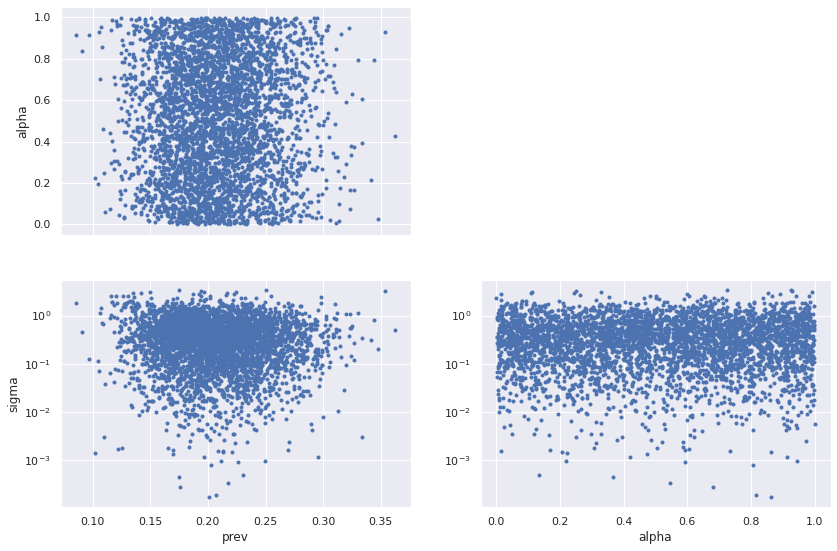

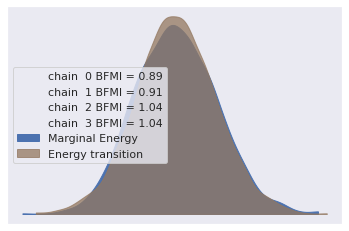

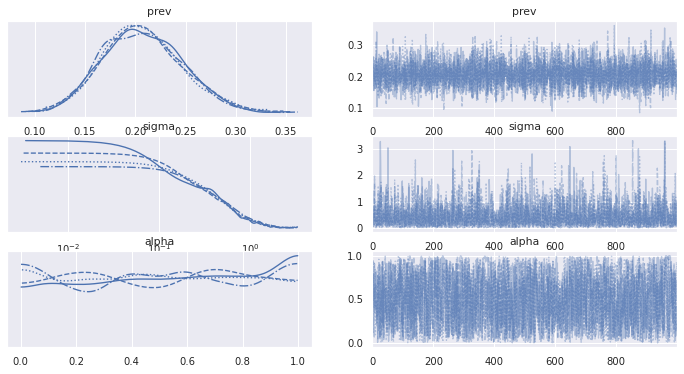

In [113]:
inference_data = az.convert_to_inference_data(fit4)
ax = az.plot_pair(inference_data, var_names=('prev', 'alpha', 'sigma'), divergences=True, group = 'posterior')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
plt.show()

az.plot_energy(fit4)
plt.show()

ax = az.plot_trace(fit4, var_names=('prev', 'sigma', 'alpha'))
ax[1,0].set_xscale('log')
plt.show()

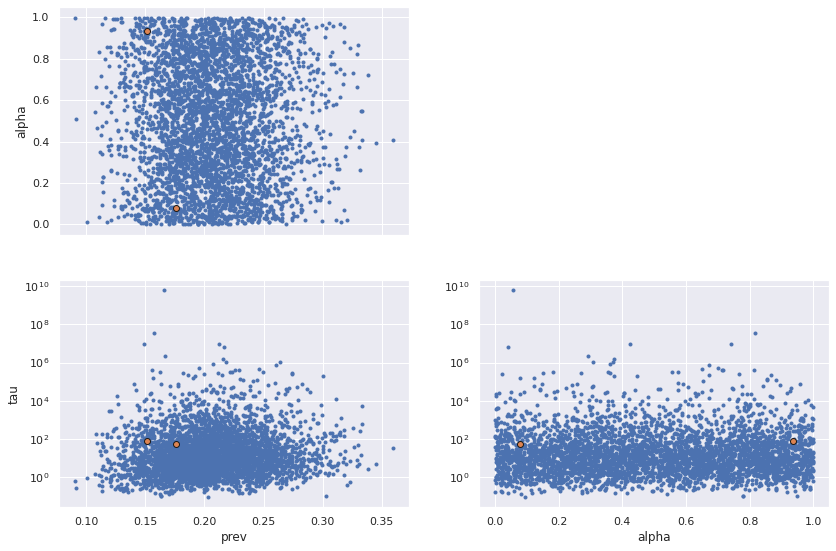

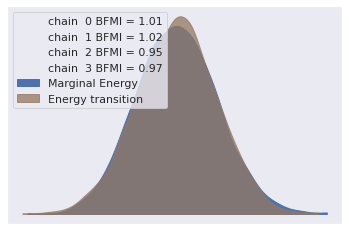

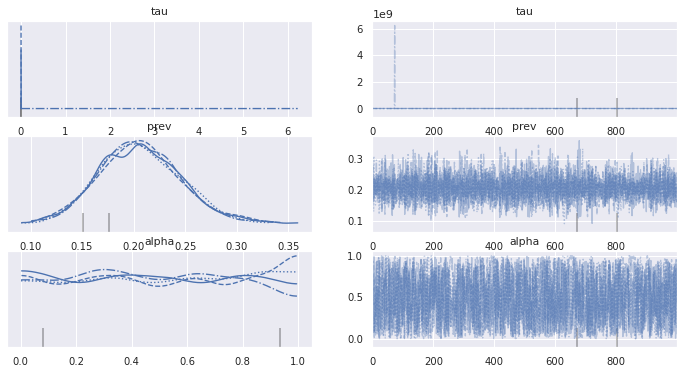

In [114]:
inference_data = az.convert_to_inference_data(fit2)
ax = az.plot_pair(inference_data, var_names=('prev', 'alpha', 'tau'), divergences=True, group = 'posterior')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
plt.show()

az.plot_energy(fit2)
plt.show()

az.plot_trace(fit2, var_names=('tau', 'prev', 'alpha'))
ax[1,0].set_xscale('log')
plt.show()

In [115]:
summary4

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi[0],-0.006,0.321,-0.641,0.553,0.005,0.006,4991.0,3050.0,1.0
phi[1],-0.031,0.468,-0.916,0.827,0.006,0.009,7051.0,2749.0,1.0
phi[2],-0.009,0.306,-0.579,0.575,0.004,0.005,5054.0,2508.0,1.0
phi[3],0.035,0.352,-0.619,0.717,0.005,0.006,5437.0,2728.0,1.0
phi[4],0.042,0.349,-0.611,0.699,0.005,0.006,5559.0,2807.0,1.0
...,...,...,...,...,...,...,...,...,...
phi[98],0.035,0.298,-0.536,0.593,0.005,0.005,4318.0,2280.0,1.0
phi[99],-0.008,0.372,-0.703,0.706,0.005,0.007,5712.0,2869.0,1.0
sigma,0.441,0.442,0.000,1.246,0.008,0.006,3039.0,2245.0,1.0
prev,0.207,0.039,0.136,0.282,0.000,0.000,7061.0,2894.0,1.0


In [116]:
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi[0],-0.010,3.210000e-01,-0.636,0.576,0.004,0.006,5421.0,2953.0,1.0
phi[1],-0.028,4.600000e-01,-0.837,0.892,0.006,0.008,5712.0,2703.0,1.0
phi[2],-0.016,3.120000e-01,-0.578,0.615,0.004,0.006,5291.0,2832.0,1.0
phi[3],0.044,3.440000e-01,-0.612,0.682,0.004,0.006,5884.0,2966.0,1.0
phi[4],0.042,3.470000e-01,-0.628,0.681,0.005,0.005,5553.0,3216.0,1.0
...,...,...,...,...,...,...,...,...,...
phi[98],0.037,2.970000e-01,-0.515,0.598,0.004,0.006,5497.0,2767.0,1.0
phi[99],-0.008,3.690000e-01,-0.669,0.716,0.005,0.007,6625.0,2641.0,1.0
tau,1577057.917,9.848641e+07,0.087,1396.657,1554071.975,1098982.542,3444.0,2681.0,1.0
prev,0.206,3.900000e-02,0.129,0.276,0.000,0.000,6660.0,2291.0,1.0


In [126]:
np.quantile(fit2.extract()['tau'], q = 0.5)

10.963878975694701

In [124]:
1/0.30936685292014166**2

10.448463770566583